In [1]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import neuraltda.plotting as tpplt
import neuraltda.spikeutils as su
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

# Setup figure save path
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20181218/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'Figure2'        # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

# Betti Parameters
analysis_id = 'BC'                # Generic lable
nperms = None                     # No permutation for each trial
ncellsperm = 33                   # Subsample 33 neurons from the population
dims = [0, 1, 2, 3]               # We want first four betti numbers
thresh = 4.0                     # Activation threshold
twin = np.linspace(0, 6000, 1000) # milliseconds

In [3]:
# Loop through each bird in our list and bin the data
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-Figure2/20181110T234608Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-Figure2/20181110T234619Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-Figure2/20181110T234634Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-Figure2/20181110T234643Z-10.0-5.0.binned


In [ ]:
# Compute for all birds
betti_data = {}
for bird in birds:
    betti_data[bird] = {}
    bdf = bdfs[bird]
    block_path = bps[bird]
    
    # Compute the betti curves for the original data
    # bc
    (bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                             thresh, nperms, ncellsperm,
                                             dims, twin, windt, dtovr, shuffle=False)
    betti_data[bird]['bc'] = bc
    betti_data[bird]['t'] = t
    betti_data[bird]['t_ms'] = t_ms

    # Compute the betti curves for shuffled-in-time data
    # This breaks the inter-neuronal coordination
    # suffix: s
    (bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=True)
    betti_data[bird]['bcs'] = bcs
    betti_data[bird]['ts'] = ts
    betti_data[bird]['ts_ms'] = ts_ms

    # Compute the betti curves for shuffled-in-trials data
    # suffix: st
    (bcst, tst, tst_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=tp2.shuffle_tensor_across_trials)
    betti_data[bird]['bcst'] = bcst
    betti_data[bird]['tst'] = tst
    betti_data[bird]['tst_ms'] = tst_ms

    # Compute the betti curves for shuffled-in-trials data
    # suffix: sts
    (bcsts, tsts, tsts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_across_trials_across_stims)
    betti_data[bird]['bcsts'] = bcsts
    betti_data[bird]['tsts'] = tsts
    betti_data[bird]['tsts_ms'] = tsts_ms

    # Compute the betti curves for shuffled-in-trials data, keeping cell spike trains intact
    # suffix: stss
    (bcstss, tstss, tstss_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_whole_spiketrains_across_stims)
    betti_data[bird]['bcstss'] = bcstss
    betti_data[bird]['tstss'] = tstss
    betti_data[bird]['tstss_ms'] = tstss_ms
    


In [18]:
def compute_betti_data(bird):
    betti_data = {}
    betti_data[bird] = {}
    bdf = bdfs[bird]
    block_path = bps[bird]

    # Compute the betti curves for the original data
    # bc
    (bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                             thresh, nperms, ncellsperm,
                                             dims, twin, windt, dtovr, shuffle=False)
    betti_data[bird]['bc'] = bc
    betti_data[bird]['t'] = t
    betti_data[bird]['t_ms'] = t_ms

    # Compute the betti curves for shuffled-in-time data
    # This breaks the inter-neuronal coordination
    # suffix: s
    (bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=True)
    betti_data[bird]['bcs'] = bcs
    betti_data[bird]['ts'] = ts
    betti_data[bird]['ts_ms'] = ts_ms

    # Compute the betti curves for shuffled-in-trials data
    # suffix: st
    (bcst, tst, tst_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=tp2.shuffle_tensor_across_trials)
    betti_data[bird]['bcst'] = bcst
    betti_data[bird]['tst'] = tst
    betti_data[bird]['tst_ms'] = tst_ms

    # Compute the betti curves for shuffled-in-trials data
    # suffix: sts
    (bcsts, tsts, tsts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_across_trials_across_stims)
    betti_data[bird]['bcsts'] = bcsts
    betti_data[bird]['tsts'] = tsts
    betti_data[bird]['tsts_ms'] = tsts_ms

    # Compute the betti curves for shuffled-in-trials data, keeping cell spike trains intact
    # suffix: stss
    (bcstss, tstss, tstss_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_whole_spiketrains_across_stims)
    betti_data[bird]['bcstss'] = bcstss
    betti_data[bird]['tstss'] = tstss
    betti_data[bird]['tstss_ms'] = tstss_ms
    return betti_data

In [83]:
def normalize_betti_curves(bc):
    ''' 
    Normalizes the betti curves to the range (0, 1) by dividing by the maximum value
    '''
    maxes = np.amax(bc, axis=1)
    maxes = np.tile(maxes[:, np.newaxis, :], (1, 1000,1))
    return np.divide(bc, maxes)

def subtract_mean_bc(bc):
    ''' 
    Subtracts the mean value of the betti curves
    '''
    #bc: nbetti x nwin x ntrial
    means = np.mean(bc, axis=1)
    means = np.tile(means[:, np.newaxis, :], (1, 1000,1))
    return bc - means

def build_betti_curve_tensor(betti_data, bird, shuffle_type='bc', betti=1, subtract_mean=False, normalize=False):
    '''
    Concatenates all betti curves into an (nstim*ntrial) x nsamples tensor
    '''
    betti_tensor = np.zeros((8*20,1000))
    bd = betti_data[bird][shuffle_type]
    stims = list(bd.keys())[0:8]
    for ind,stim in enumerate(stims):
        bc = bd[stim]
        if normalize:
            bc = normalize_betti_curves(bc)
        if subtract_mean:
            bc = subtract_mean_bc(bc)
        #print(bc.shape)
        for trial in range(20):
            betti_tensor[ind*20+trial, :] = bc[betti, :, trial]
    return betti_tensor

def compute_pairwise_cosine_similarity(betti_tensor):
    #bt = np.reshape(betti_tensor, (8*20,1000))
    bt = betti_tensor
    btnorms = np.sqrt(np.sum(bt**2, axis=1))
    btnorms = np.multiply.outer(btnorms, btnorms)
    #btsq = np.tensordot(bt, bt, axes=([1], [1]))
    btsq = np.dot(bt, bt.T) / 1000.
            
    return np.divide(btsq, btnorms)

def compute_pairwise_correlations(betti_tensor):
    return np.corrcoef(betti_tensor)
    

In [ ]:
def compute_cos_var_ratio(betti_data, bird, shuffle_type, betti, subtract_mean=False, normalize=False):
    btens = build_betti_curve_tensor(betti_data,bird, shuffle_type=shuffle_type, betti=betti, subtract_mean=subtract_mean, normalize=normalize)
    #cos_sim = compute_pairwise_cosine_similarity(btens)
    cos_sim = compute_pairwise_correlations(btens)
    #get within stim variances of cosine similarity
    in_vars = []
    for stim in range(8):
        stim_sim = cos_sim[stim*20:(stim+1)*20, stim*20:(stim+1)*20]
        stim_sim_ut = stim_sim[np.triu_indices(20, 1)]
        in_stim_var = np.var(stim_sim_ut)
        in_vars.append(in_stim_var)

    # get total variance
    tot_ut = cos_sim[np.triu_indices(160, 1)]
    tot_var = np.var(tot_ut)

    #compute variance ratios:
#     print(in_vars)
#     print(tot_var)
#     print(tot_var/in_vars)
    #print('{} {} Betti {} Avg Var Ratio: '.format(bird, shuffle_type, betti) + str(np.nanmean(tot_var/in_vars)))
    return np.nanmean(tot_var/in_vars)

In [84]:
def compute_corr_distributions(betti_data, bird, shuffle_type, betti, subtract_mean=False, normalize=False):
    '''
    Compute the distributions of correlations between betti curves between stimuli and across stimuli
    '''
    btens = build_betti_curve_tensor(betti_data,bird, shuffle_type=shuffle_type, betti=betti, subtract_mean=subtract_mean, normalize=normalize)
    #cos_sim = compute_pairwise_cosine_similarity(btens)
    pairwise_correlations = compute_pairwise_correlations(btens)
    in_stim_corrs = []
    btwn_stim_corrs = []
    for stim in range(8):
        # Extract within-stimuli correlations
        stim_sim = pairwise_correlations[stim*20:(stim+1)*20, stim*20:(stim+1)*20]
        stim_sim_ut = stim_sim[np.triu_indices(20, 1)]
        in_stim_corrs.append(stim_sim_ut)
        
        # Extract between-stimuli correlations
        for stim2 in range(stim+1, 8):
            btwn_sim = pairwise_correlations[stim*20:(stim+1)*20, stim2*20:(stim2+1)*20].flatten()
            btwn_stim_corrs.append(btwn_sim)
    return (in_stim_corrs, btwn_stim_corrs)

In [69]:
 

stypes = ['bc', 'bcs', 'bcst', 'bcsts', 'bcstss']
import tqdm
ratio_data = {}
for bird in birds:
    ratio_data[bird] = {}
    for betti in [0,1,2]:
        ratio_data[bird][betti] = {}
        for shuffle_type in stypes:
            ratio_data[bird][betti][shuffle_type] = []
            
nreps = 10
for rep in tqdm.tqdm(range(nreps)):
    for bird in birds:
        betti_data = compute_betti_data(bird)
        #print(bird, betti_data.keys())
        for betti in [0, 1,2]:
            for shuffle_type in stypes:
                var_rat = compute_cos_var_ratio(betti_data, bird, shuffle_type, betti, subtract_mean=False, normalize=False)
                ratio_data[bird][betti][shuffle_type].append(var_rat)

  0%|          | 0/10 [00:00<?, ?it/s]

AttributeError: module 'numpy' has no attribute 'corrcoeff'

In [85]:
stypes = ['bc', 'bcs', 'bcst', 'bcsts', 'bcstss']
import tqdm
ratio_data = {}
for bird in birds:
    ratio_data[bird] = {}
    for betti in [0,1,2]:
        ratio_data[bird][betti] = {}
        for shuffle_type in stypes:
            ratio_data[bird][betti][shuffle_type] = []
            
nreps = 1
for rep in tqdm.tqdm(range(nreps)):
    for bird in birds:
        betti_data = compute_betti_data(bird)
        #print(bird, betti_data.keys())
        for betti in [0, 1,2]:
            for shuffle_type in stypes:
                corr_distribs = compute_corr_distributions(betti_data, bird, shuffle_type, betti, subtract_mean=False, normalize=False)
                ratio_data[bird][betti][shuffle_type] = corr_distribs

  0%|          | 0/1 [00:00<?, ?it/s]/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_b

[2, 3, 4, 5, 6, 7]

In [ ]:
import pickle
with open(os.path.join(figsavepth, 'ratio_data-corrcoeff.pkl'), 'wb') as f:
    pickle.dump(ratio_data, f)

In [71]:
with open(os.path.join(figsavepth, 'ratio_data-normalizedbc.pkl'), 'rb') as f:
    ratio_data = pickle.load(f)

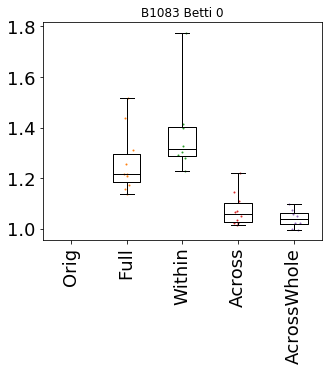

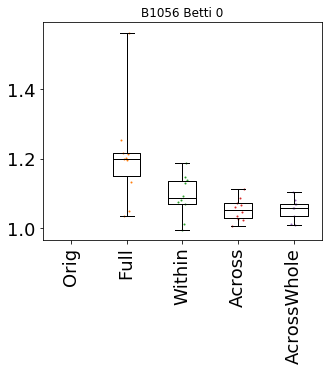

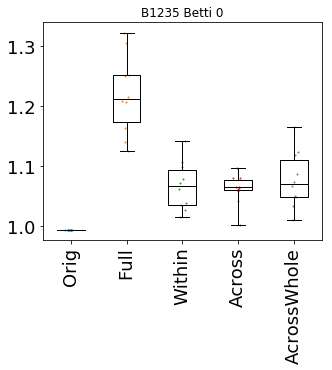

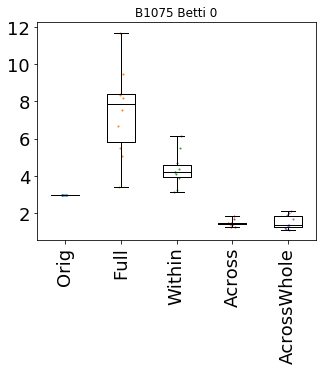

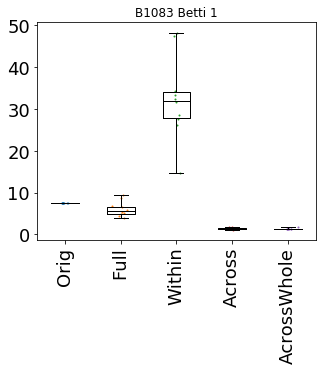

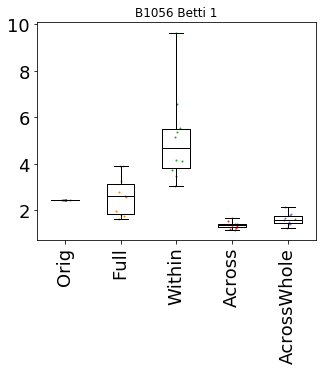

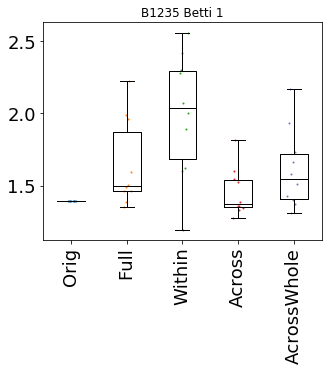

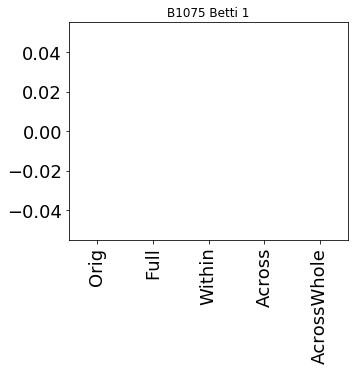

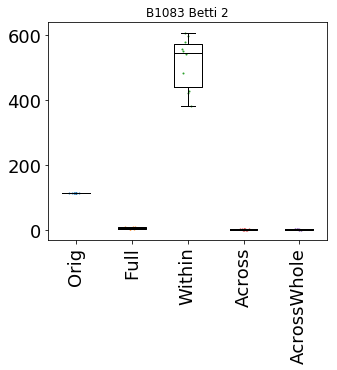

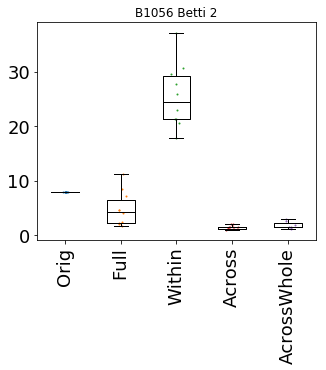

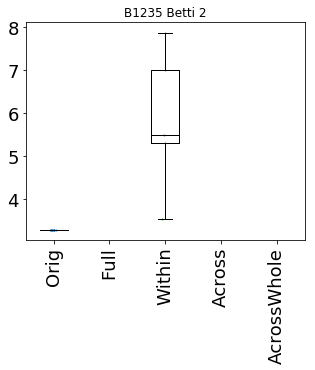

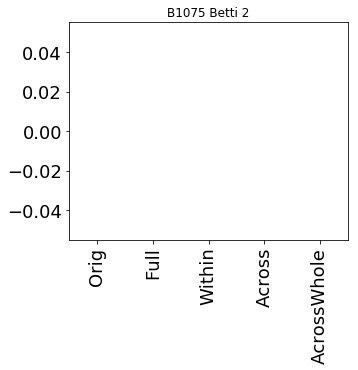

In [78]:
type_labels = ['Orig', 'Full', 'Within', 'Across', 'AcrossWhole']

for betti in [0,1,2]:
    plotdat = []
    #print('\n\n')
    for bird in birds:
        #print('\n')
        plotdat=[]
        for tp in stypes:
            x = np.array(ratio_data[bird][betti][tp])
            plotdat.append(x[~np.isnan(x)])
            #print(ratio_data[bird][betti][tp])
            
        grouped_boxplot_with_scatter(plotdat, range(len(plotdat)), ngroups=5, labels=type_labels)
        plt.title('{} Betti {}'.format(bird, betti))
        plt.savefig(figsavepth+'{}-{}-shuffles.pdf'.format(bird, betti))
#     plt.title('{} Betti {}'.format(bird, betti))

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


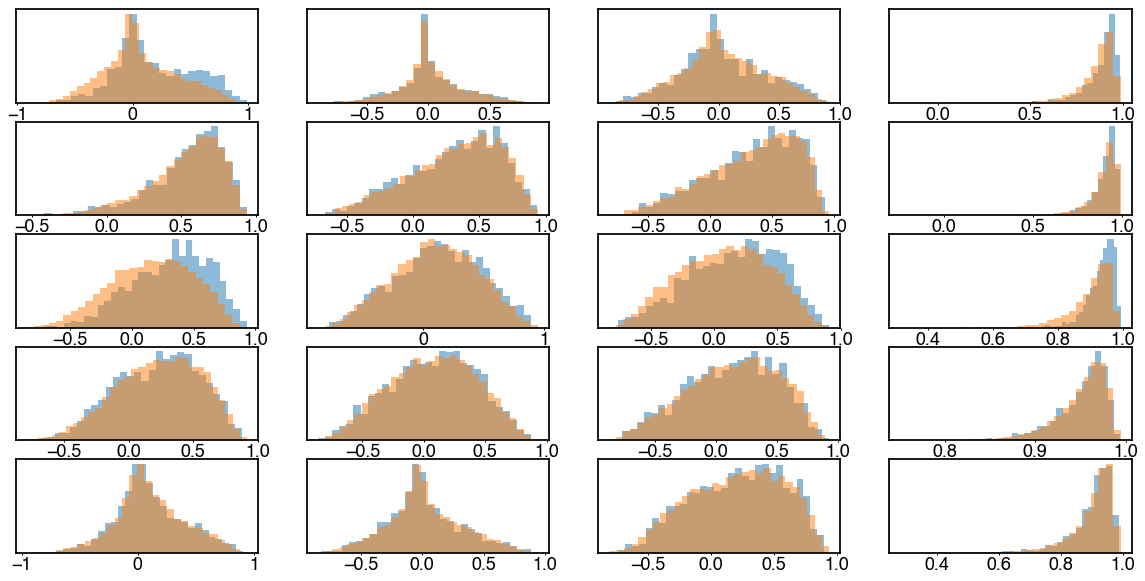

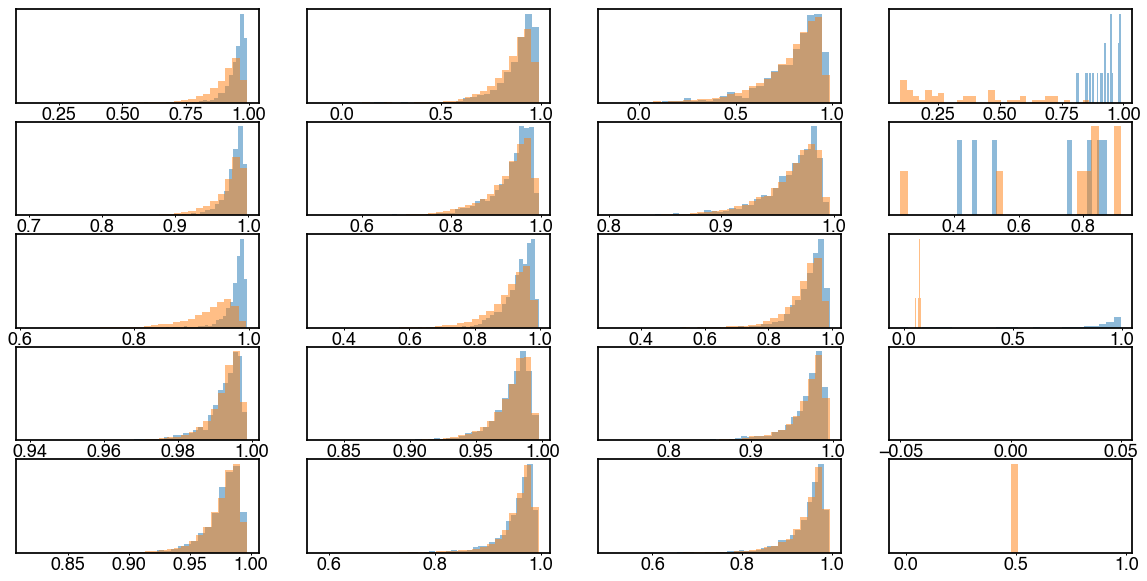

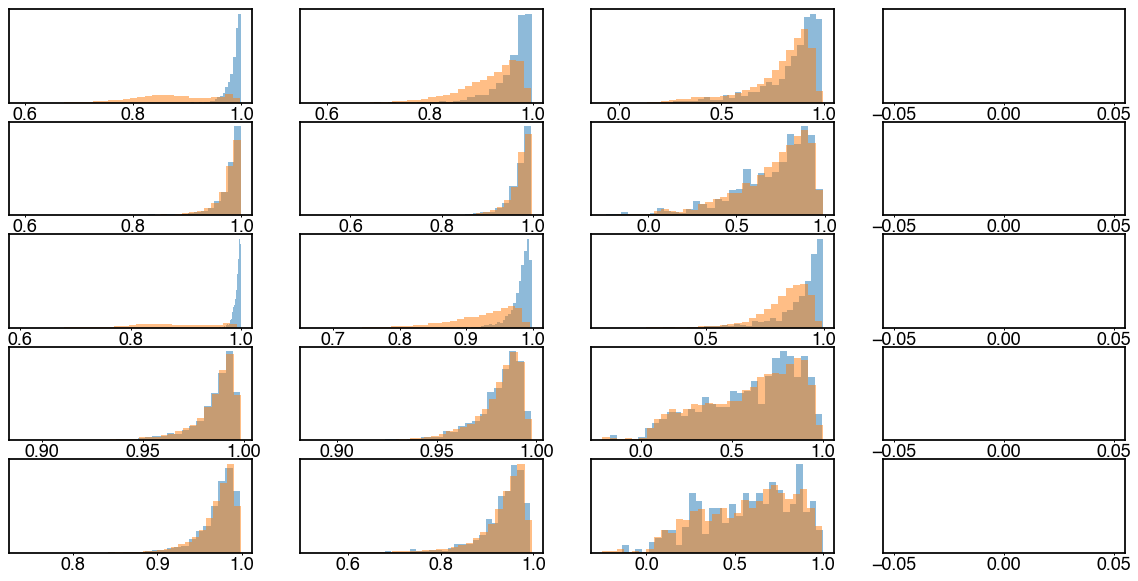

In [119]:
# type_labels = ['Orig', 'Full', 'Within', 'Across', 'AcrossWhole']
#plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
for betti in [0,1,2]:
    plotdat = []
    fig = plt.figure(figsize=(20,10))
    #print('\n\n')
    for ind, bird in enumerate(birds):
        
        #print('\n')
        plotdat=[]
        for ind2, tp in enumerate(stypes):
            in_stim, btwn_stim = ratio_data[bird][betti][tp]
            in_stim = np.array(in_stim).flatten()
            btwn_stim = np.array(btwn_stim).flatten()
            in_stim = in_stim[~np.isnan(in_stim)]
            btwn_stim = btwn_stim[~np.isnan(btwn_stim)]
            #print(5*ind+ind2)
            ax = fig.add_subplot(5, 4, ind+4*ind2+1)
            
            ax.hist(in_stim, bins=30, alpha=0.5, density=True)
            ax.hist(btwn_stim, bins=30, alpha=0.5, density=True)
            ax.set_yticks([])
            
            #print(ratio_data[bird][betti][tp])
    #plt.title('{} Betti {} Type {}'.format(bird, betti, tp))
    plt.savefig(figsavepth+'Betti{}-distrib.pdf'.format(betti))
#     plt.title('{} Betti {}'.format(bird, betti))

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


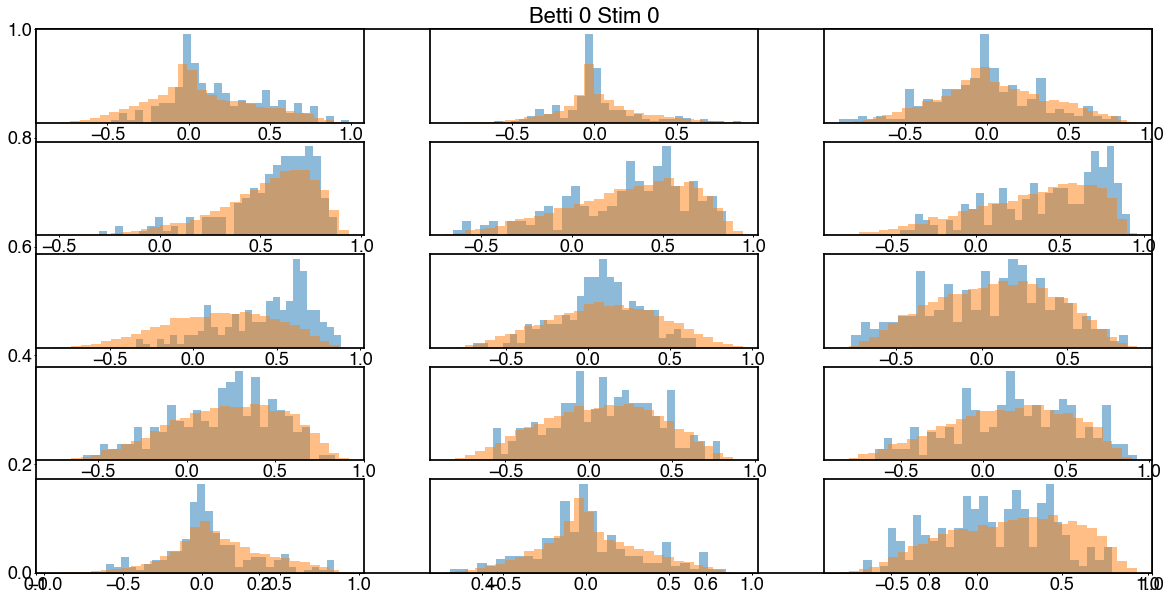

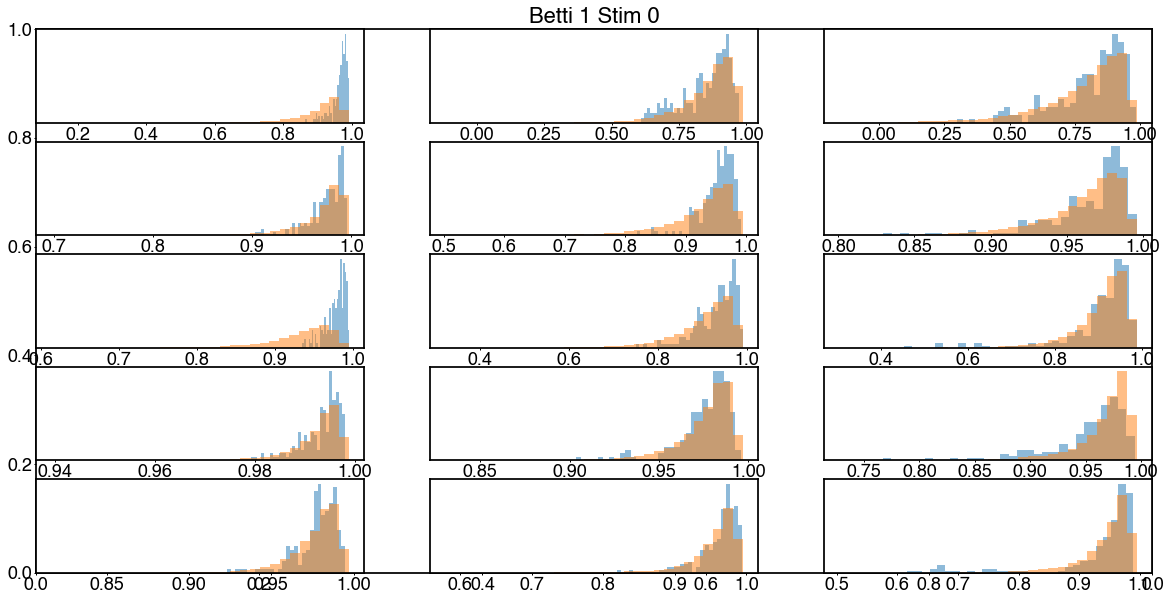

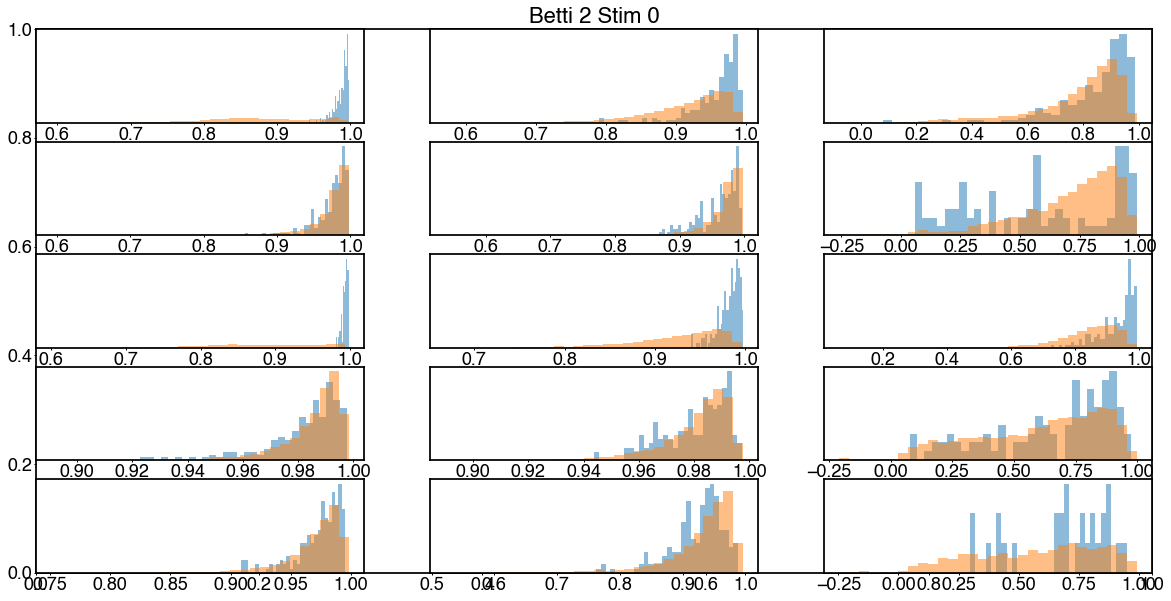

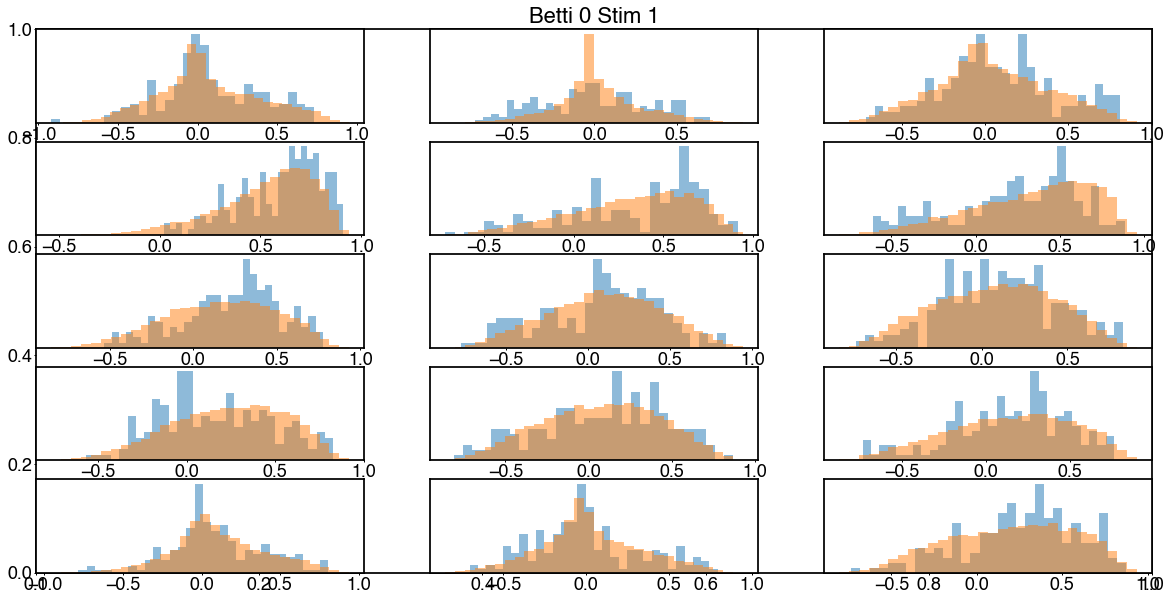

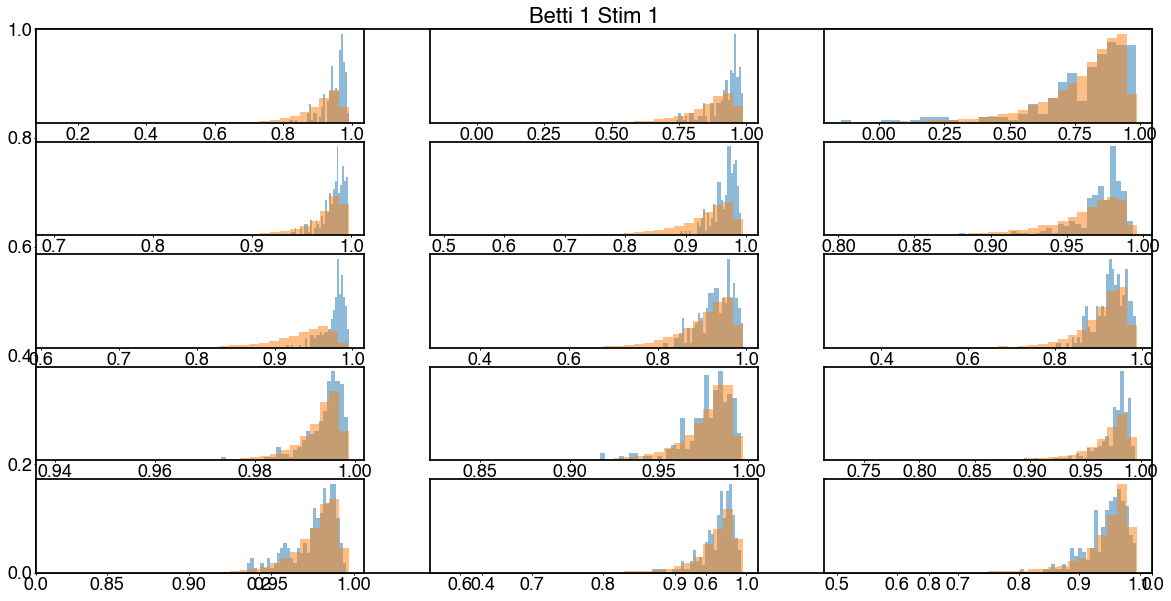

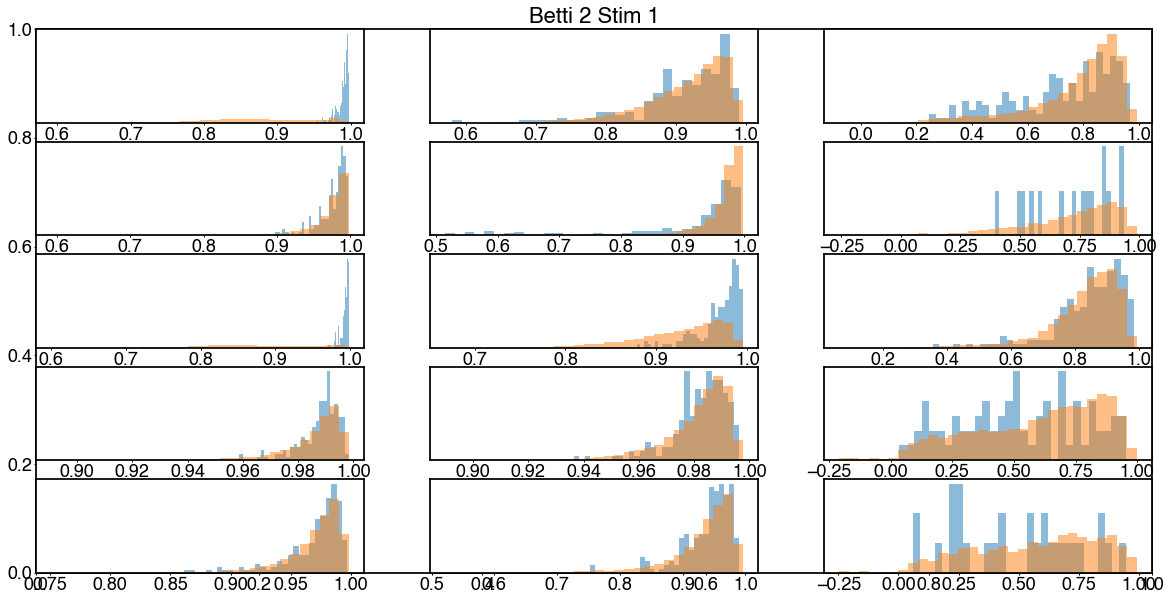

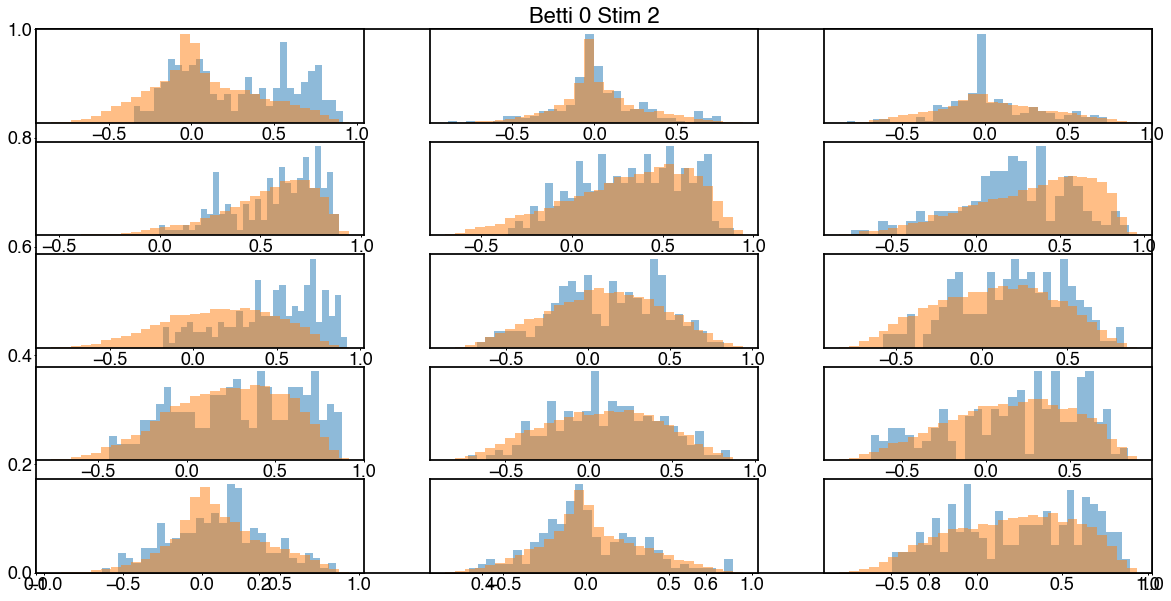

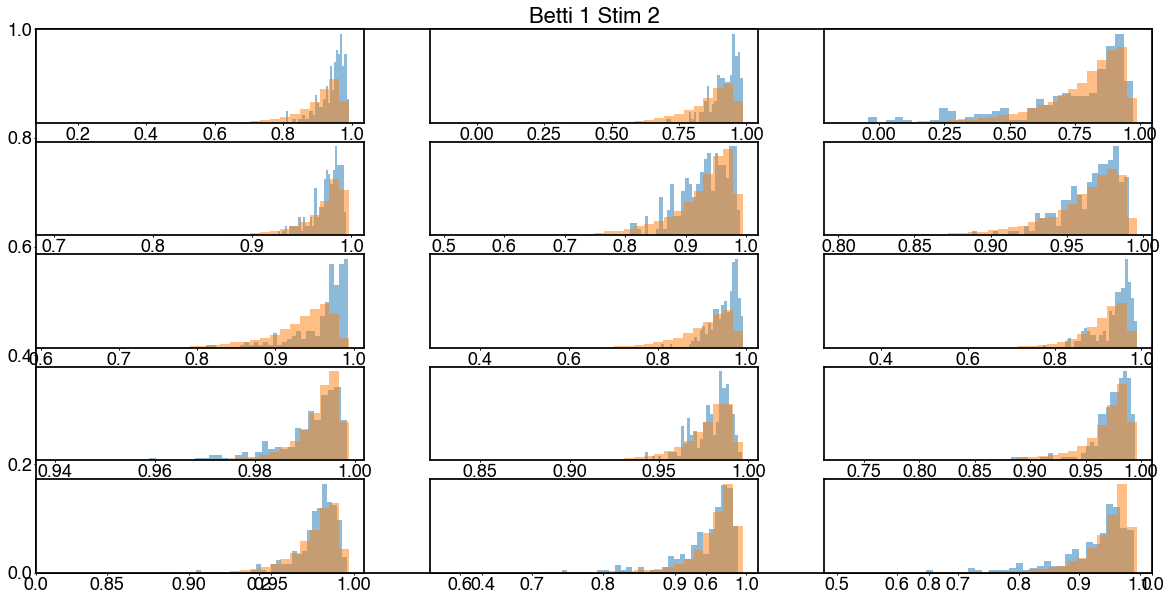

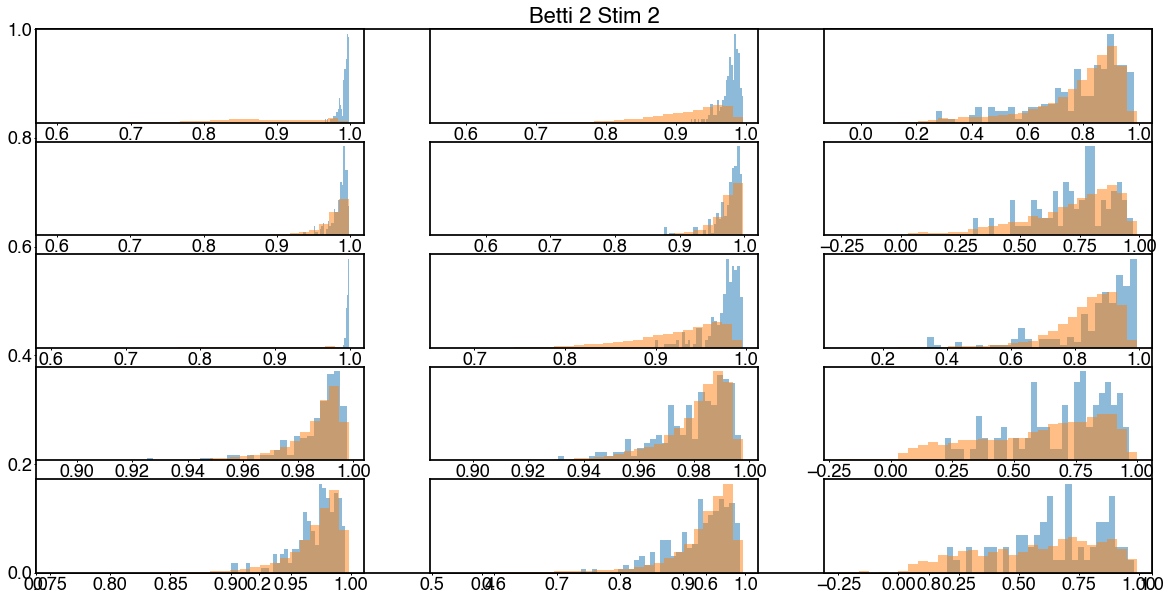

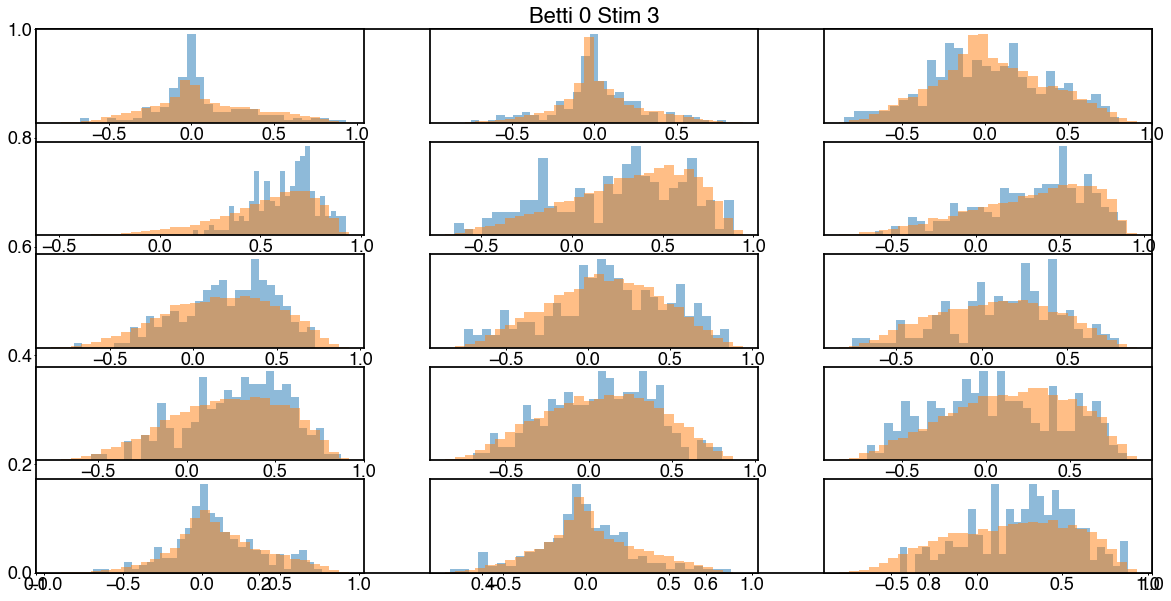

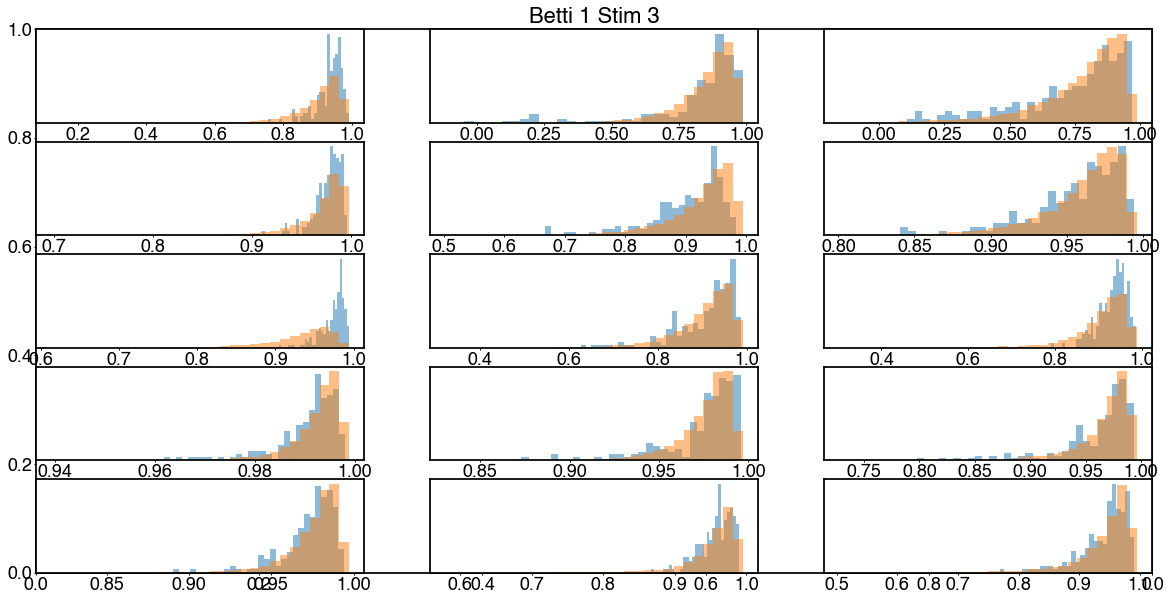

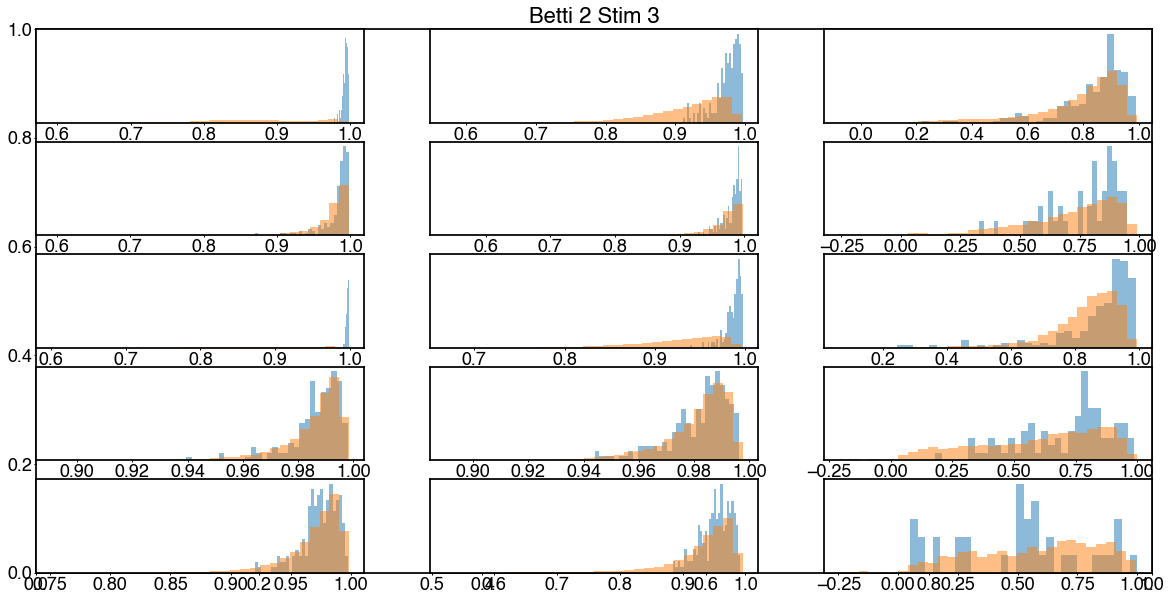

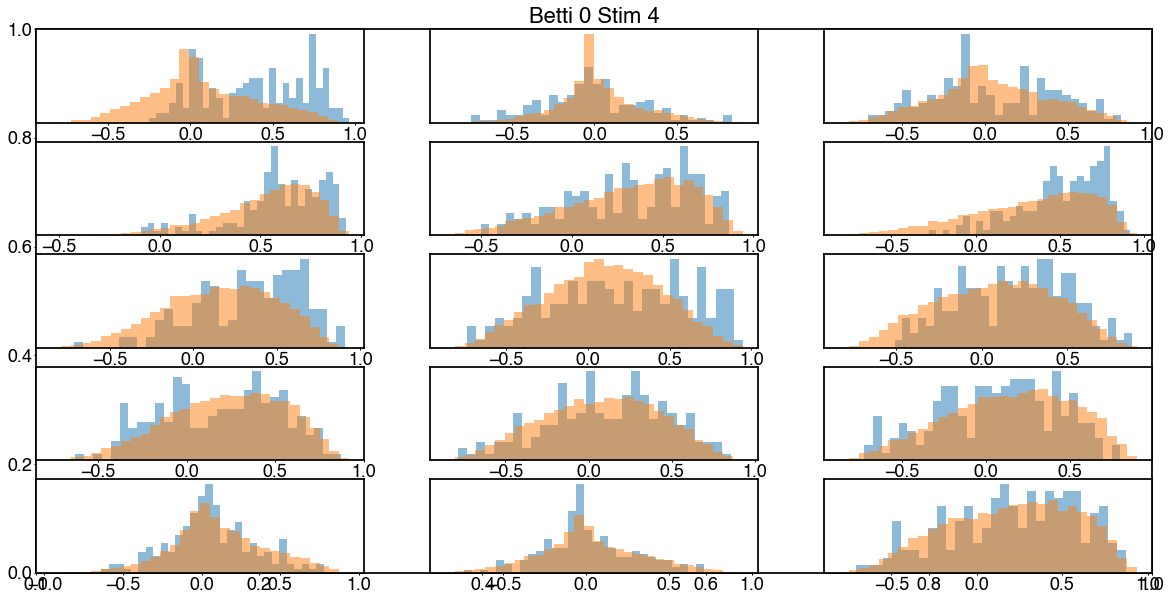

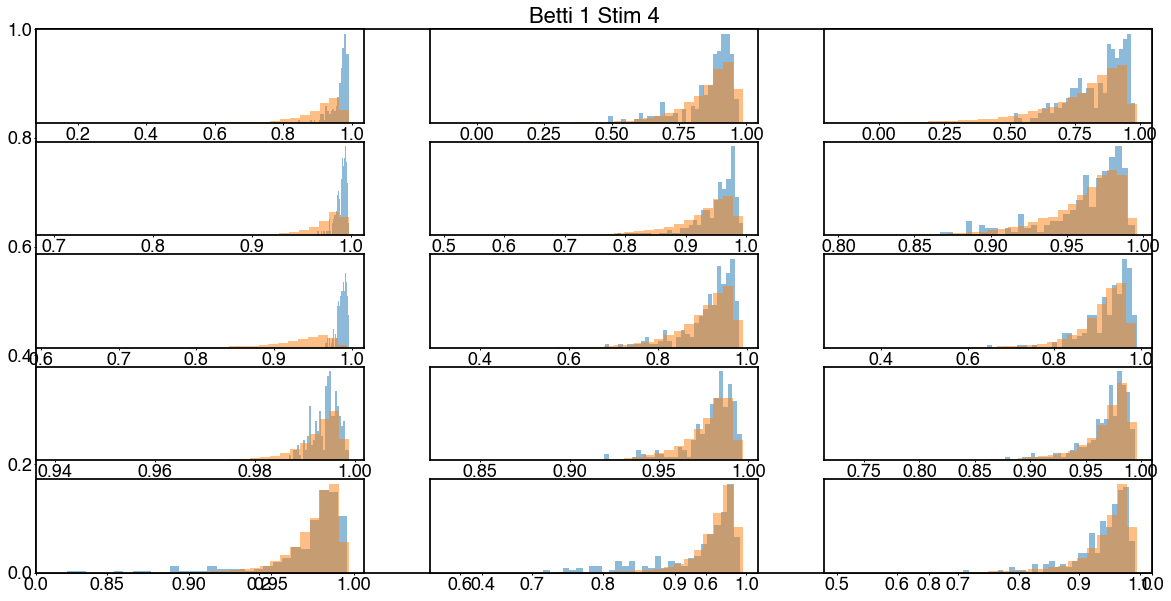

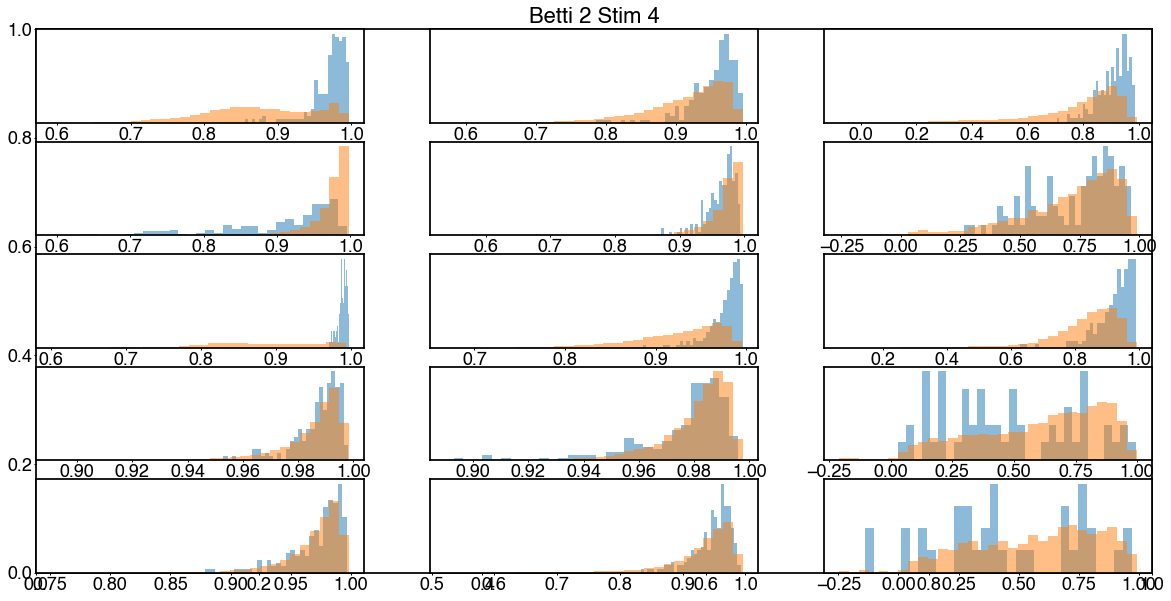

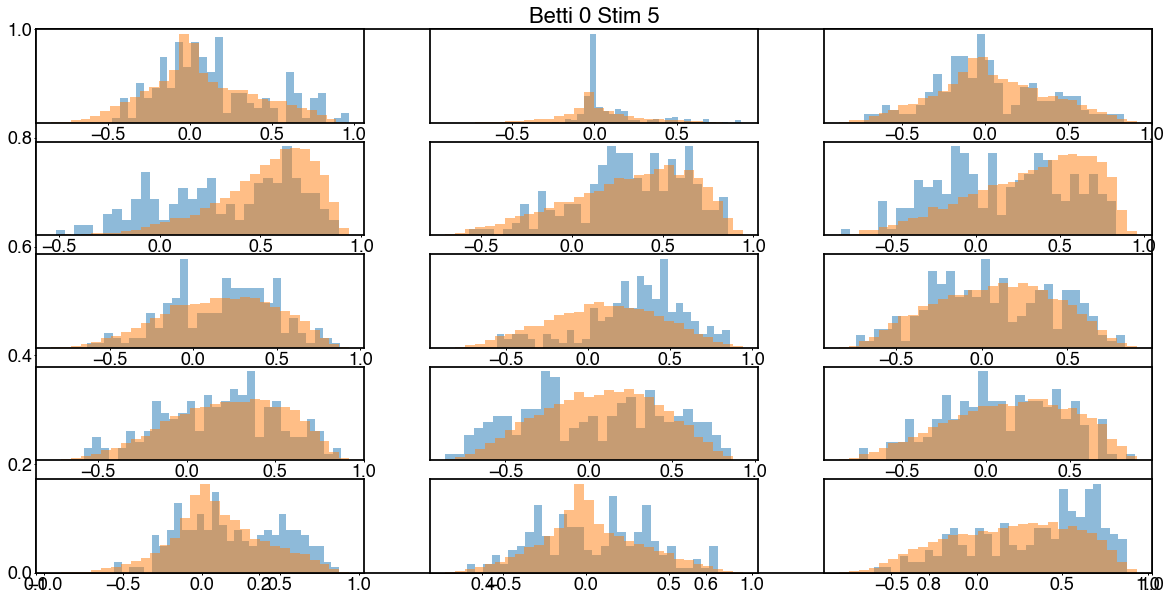

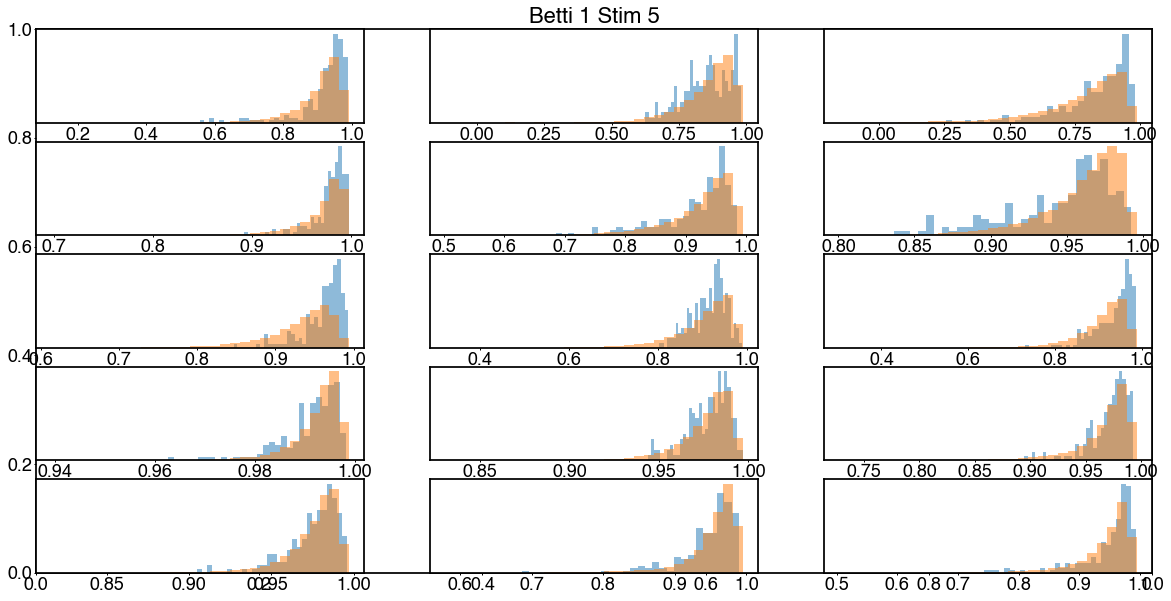

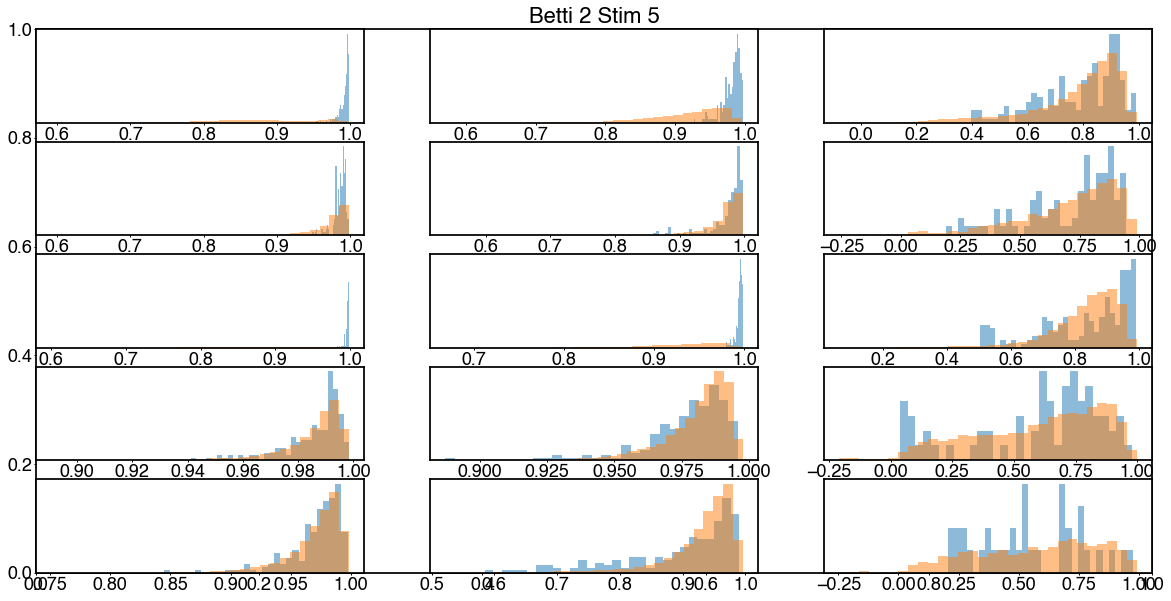

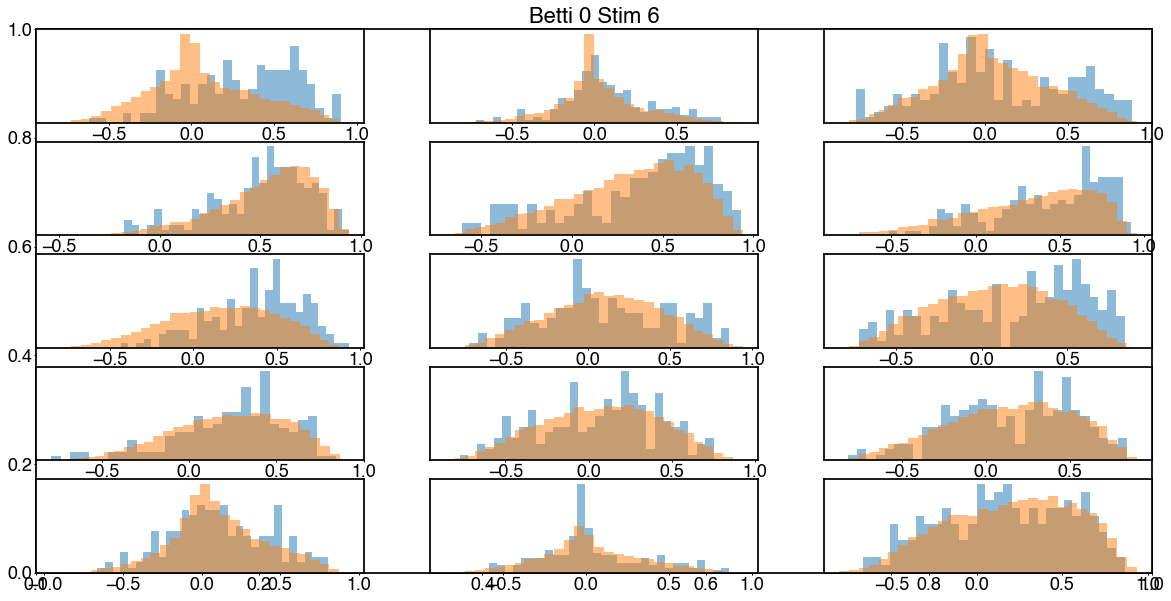

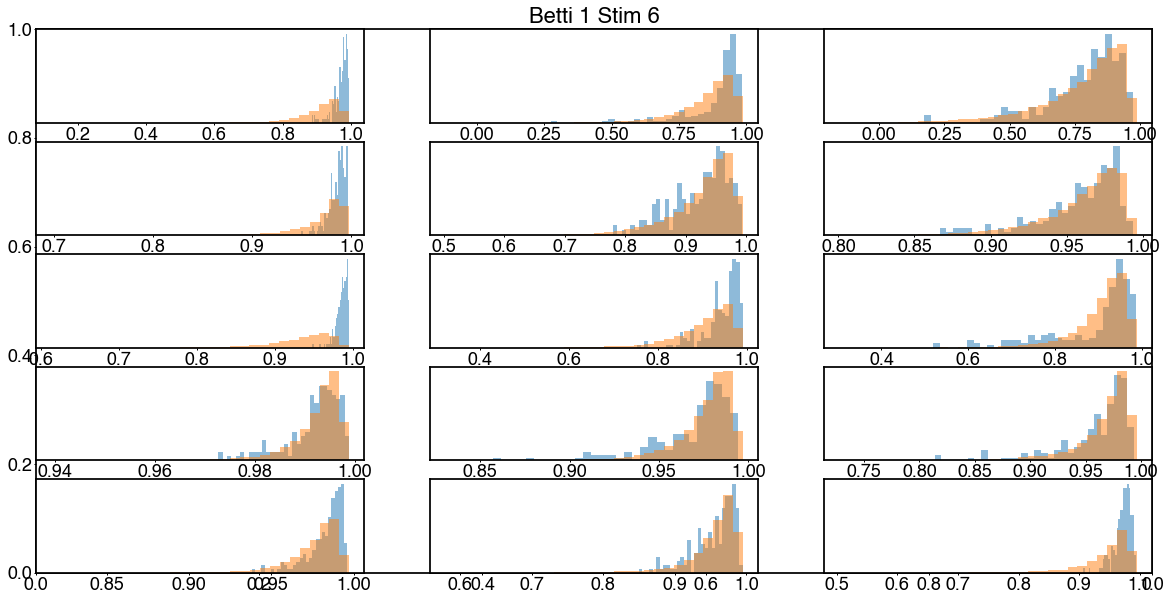

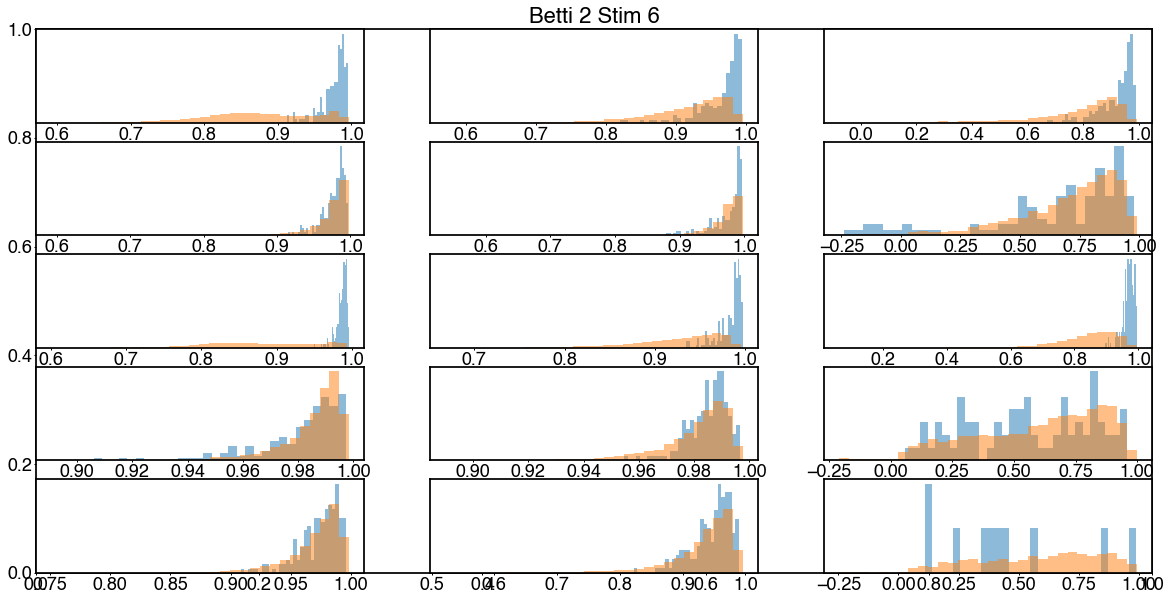

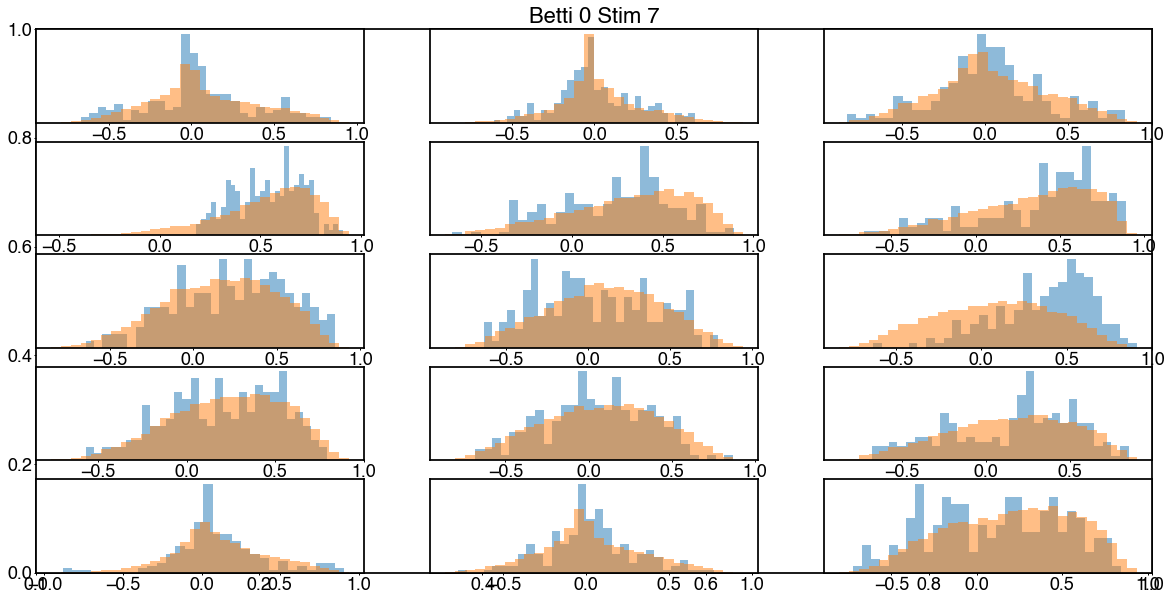

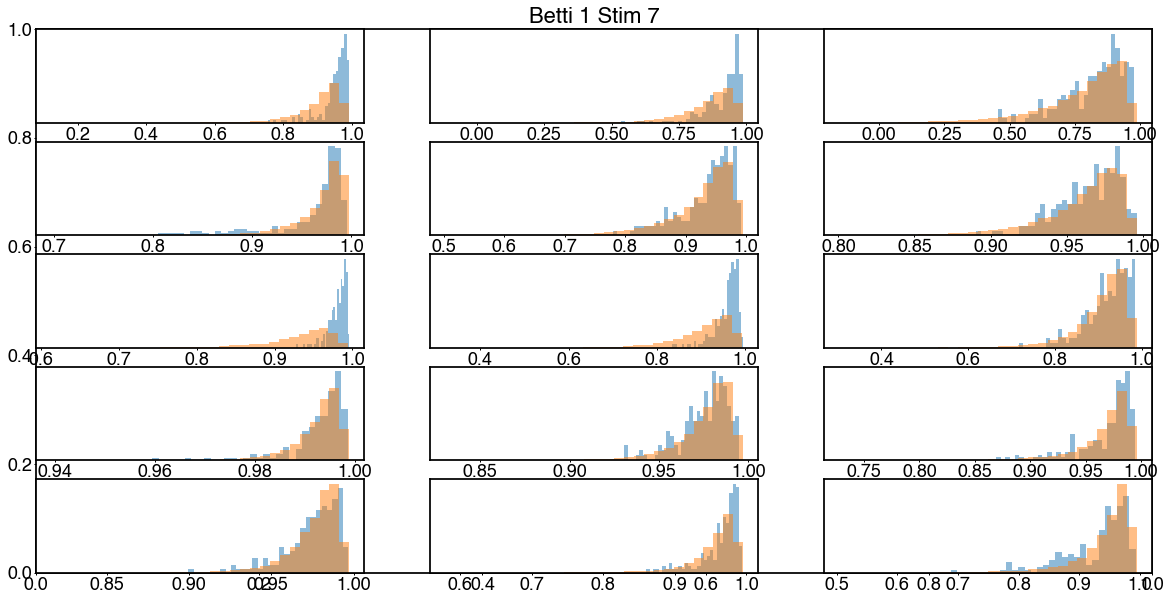

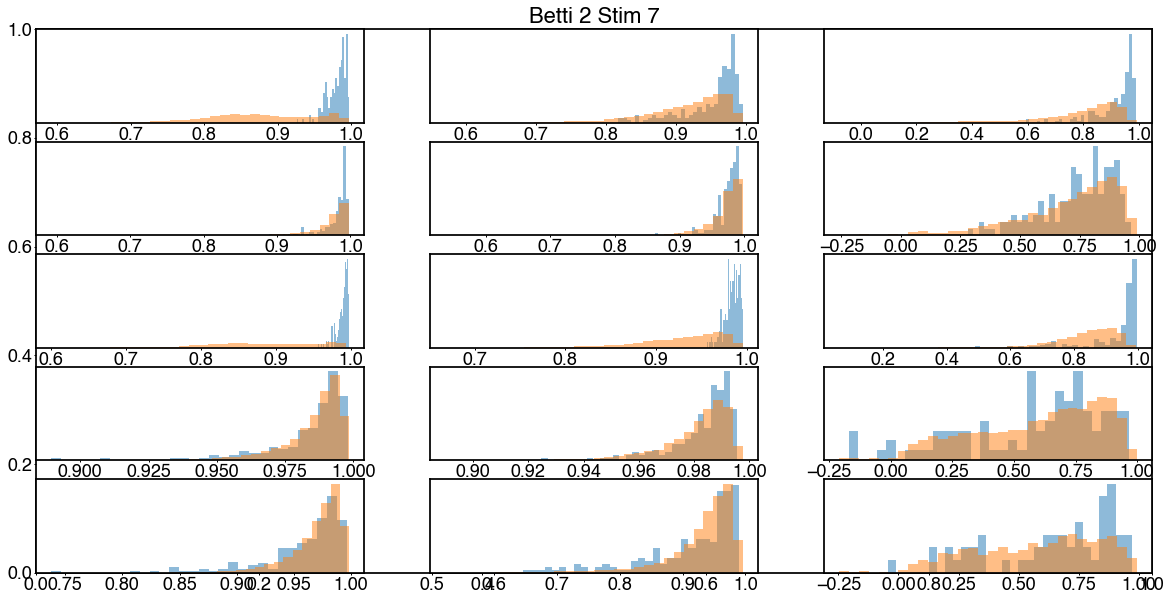

In [126]:
# type_labels = ['Orig', 'Full', 'Within', 'Across', 'AcrossWhole']
#plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
for stim in range(8):
    for betti in [0,1,2]:
        plotdat = []
        fig = plt.figure(figsize=(20,10), frameon=False)
        plt.title('Betti {} Stim {}'.format(betti, stim))
        #print('\n\n')
        for ind, bird in enumerate(birds[0:3]):

            #print('\n')
            plotdat=[]
            for ind2, tp in enumerate(stypes):
                in_stim, btwn_stim = ratio_data[bird][betti][tp]

                in_stim = np.array(in_stim[stim]).flatten()
                btwn_stim = np.array(btwn_stim).flatten()
                in_stim = in_stim[~np.isnan(in_stim)]
                btwn_stim = btwn_stim[~np.isnan(btwn_stim)]
                #print(5*ind+ind2)
                ax = fig.add_subplot(5, 3, ind+3*ind2+1)

                ax.hist(in_stim, bins=30, alpha=0.5, density=True)
                ax.hist(btwn_stim, bins=30, alpha=0.5, density=True)
                ax.set_yticks([])

                #print(ratio_data[bird][betti][tp])
        #plt.title('{} Betti {} Type {}'.format(bird, betti, tp))
        
        plt.savefig(figsavepth+'Betti{}-stim{}-distrib.pdf'.format(betti, stim))
    #     plt.title('{} Betti {}'.format(bird, betti))

In [ ]:
def compute_cos_var_ratio(betti_data, bird, shuffle_type, betti):
    btens = build_betti_curve_tensor(betti_data,bird, shuffle_type=shuffle_type, betti=betti)
    cos_sim = compute_pairwise_cosine_similarity(btens)
    #get within stim variances of cosine similarity
    in_vars = []
    for stim in range(8):
        stim_sim = cos_sim[stim*20:(stim+1)*20, stim*20:(stim+1)*20]
        stim_sim_ut = stim_sim[np.triu_indices(20, 1)]
        in_stim_var = np.var(stim_sim_ut)
        in_vars.append(in_stim_var)

    # get total variance
    tot_ut = cos_sim[np.triu_indices(160, 1)]
    tot_var = np.var(tot_ut)

    #compute variance ratios:
#     print(in_vars)
#     print(tot_var)
#     print(tot_var/in_vars)
    print('{} {} Betti {} Avg Var Ratio: '.format(bird, shuffle_type, betti) + str(np.nanmean(tot_var/in_vars)))

for bird in birds:
    for betti in [0, 1,2]:
        for shuffle_type in ['bc', 'bcs', 'bcst', 'bcsts', 'bcstss']:
            compute_cos_var_ratio(betti_data, bird, shuffle_type, betti)

In [ ]:
betti_data[bird]['bcsts']['I_40k'].shape

In [ ]:
def compute_variance_ratio(bcurves, normalize=False):
    '''
    Compute ratio of variance across stim / within stims
    greater than 1 means less stimulus selective, less than 1 means stimulus selective
    
    '''
    all_stim_bettis = np.zeros((4, 1000, 0))
    in_stim_vars = {}
    for stim in bcurves.keys():
        betti_curves = bcurves[stim]
        if normalize:
            betti_curves = normalize_betti_curves(betti_curves)
        in_stim_var = np.mean(np.var(betti_curves, axis=2), axis=1)
        in_stim_vars[stim] = in_stim_var

        all_stim_bettis = np.concatenate((all_stim_bettis, np.mean(betti_curves, axis=2)[:, :, np.newaxis]), axis=2)
    across_stim_var = np.mean(np.var(all_stim_bettis, axis=2), axis=1)
    
    var_ratios = {}
    ratios = []
    mean_ratio = np.zeros(4)
    ratios = np.zeros((4, len(in_stim_vars.keys())))
    for ind, stim in enumerate(in_stim_vars.keys()):
        in_stim_var = in_stim_vars[stim]
        var_ratios[stim] = np.divide(across_stim_var, in_stim_var, )
        mean_ratio += var_ratios[stim]
        ratios[:, ind] = var_ratios[stim]
    #ratios = np.concatenate([var_ratios[stim] for stim in var_ratios.keys()])
    #print(ratios)
    mean_ratio = np.nanmean(ratios, axis=1)
    std_ratio = np.nanstd(ratios, axis=1)
    return (var_ratios, mean_ratio, std_ratio)

def avg_var_ratios_across_birds(var_ratios):
    vr_save = np.empty((4, 0))
    for bird in var_ratios.keys():
        bird_var_ratios = var_ratios[bird]
        for stim in bird_var_ratios.keys():
            ratios = bird_var_ratios[stim] # nbetti x 1

            vr_save = np.concatenate((vr_save, ratios[:, np.newaxis]), axis=1)
    # vr_save is nbetti x (nbird*nstim)
    # compute stats across birds/stims
    vr_mean = np.nanmean(vr_save, axis=1)
    vr_std = np.nanstd(vr_save, axis=1)
    return (vr_mean, vr_std)

def compute_var_ratio_bird_avg(betti_data, shuffle_type, nm=True):
    vr = {}
    for bird in birds:
        var_ratios, _, _ = compute_variance_ratio(betti_data[bird][shuffle_type], normalize=nm)
        vr[bird] = var_ratios
    vr_mean, vr_std = avg_var_ratios_across_birds(vr)
    return (vr_mean, vr_std)

In [ ]:
bird = 'B1083'
nm = True
#bird='B1235'
var_ratios, mean_ratio, std_ratio = compute_variance_ratio(betti_data[bird]['bc'], normalize=nm)
print(var_ratios['I_40k'].shape)
print(mean_ratio)
print(std_ratio)

var_ratios, mean_ratio, std_ratio = compute_variance_ratio(betti_data[bird]['bcs'], normalize=nm)
#print(var_ratios)
print(mean_ratio)
print(std_ratio)

var_ratios, mean_ratio, std_ratio = compute_variance_ratio(betti_data[bird]['bcst'], normalize=nm)
#print(var_ratios)
print(mean_ratio)
print(std_ratio)

var_ratios, mean_ratio, std_ratio = compute_variance_ratio(betti_data[bird]['bcsts'], normalize=nm)
#print(var_ratios)
print(mean_ratio)
print(std_ratio)

var_ratios, mean_ratio, std_ratio = compute_variance_ratio(betti_data[bird]['bcstss'], normalize=nm)
#print(var_ratios)
print(mean_ratio)
print(std_ratio)

In [ ]:
compute_var_ratio_bird_avg(betti_data, 'bc')

In [ ]:
def get_var_ratios(betti_data, bird):
    cv_var_ratios = {}
    var_ratios, mean_ratio = compute_variance_ratio(betti_data[bird]['bc'], normalize=nm)
    cv_var_ratios['bc'] = var_ratios


    var_ratios, mean_ratio = compute_variance_ratio(betti_data[bird]['bcs'], normalize=nm)
    cv_var_ratios['bcs'] = var_ratios


    var_ratios, mean_ratio = compute_variance_ratio(betti_data[bird]['bcst'], normalize=nm)
    cv_var_ratios['bcst'] = var_ratios


    var_ratios, mean_ratio = compute_variance_ratio(betti_data[bird]['bcsts'], normalize=nm)
    cv_var_ratios['bcsts'] = var_ratios
    var_ratios, mean_ratio = compute_variance_ratio(betti_data[bird]['bcstss'], normalize=nm)
    cv_var_ratios['bcstss'] = var_ratios
    return cv_var_ratios


# make boxplot data
bettis = [0,1,2]
boxplot_data = []
for bird in birds:
    cv_var_ratios = get_var_ratios(betti_data, bird)
    for betti in bettis:
        for suffix in cv_var_ratios.keys():
            betti_ratio_list = []
            var_ratios = cv_var_ratios[suffix]
            for stim in var_ratios.keys():
                betti_ratio_list.append(var_ratios[stim][betti])
            betti_ratios = np.array(betti_ratio_list)
            boxplot_data.append(betti_ratios)

boxplot_data

In [ ]:
print(bird)
print(np.amax(betti_data[bird]['bc']['I_40k'], axis=1).shape)
0.75786*2

In [ ]:
bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(betti_data[bird]['bcs'])
print(bcs_plot_dict['I_40k'][0].shape)

In [ ]:
betti=2
for stim in bcs_plot_dict.keys():
    cv = bcs_plot_dict[stim][0][betti, :]
    cv = cv / np.amax(cv)
    plt.plot(cv)

In [ ]:
betti_data[bird]['bc']['I_40k'].shape

In [77]:
def grouped_boxplot_with_scatter(data, order, ngroups=1, group_spacing=2, fig_path=None, colors=None, alphas=None, labels=None, positions=None, scatter_style=None, marker_size = 1, figsize=(5,4)):
    ''' From Zeke 
        Plot grouped boxplots
        data is in the form of a list of arrays, Ngroups*nboxes/group
    
    '''
    #colors = np.array(['pink', 'lightblue', 'lightgreen', 'pink', 'lightblue', 'lightgreen'])
    #alphas = np.array([0.25, 0.25, 0.25, 0.75, 0.75, 0.75])
    #labels = np.array(['CON/BOS', 'CON/Mot-wise', 'CON/Pc-wise', 'BOS/BOS', 'BOS/Mot-wise', 'BOS/Pc-wise'])
   
    nboxes = len(data)
    if alphas is None:
        alphas = np.array(nboxes*[1.0])
        
    dat_plot = [data[i] for i in order]
    
    # compute positions
    nboxes_per_group = int(int(len(data)) / int(ngroups))
    positions = np.arange(nboxes_per_group) +1
    for group in range(1, ngroups):
        positions = np.concatenate([positions, np.arange(max(positions)+group_spacing, max(positions)+group_spacing+nboxes_per_group)])
        
    
    box_plot_fig = plt.figure(figsize=figsize)
    ax = box_plot_fig.add_subplot(111)
    
    medianprops = dict(color='black')
    if positions is not None:
        box_plot = ax.boxplot(dat_plot, 0, '', positions=positions, patch_artist=False, whis='range', widths=1,
                              medianprops=medianprops)
        xlim1 = max(positions)+1
    else:
        box_plot = ax.boxplot(dat_plot, 0, '', patch_artist=False, whis='range', widths=1, medianprops=medianprops)
        xlim1 = max(order)+1

        
    # Do scatter
    scatter_plots = []
    
    for i in order:
        xs = np.array(len(data[i])*[positions[i]])+0.1*np.random.randn(len(data[i]))
        if scatter_style is None:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1) 
        else:
            scatter_plot = ax.scatter(xs, data[i], s=marker_size, alpha=1, marker=scatter_style[i])
        scatter_plots.append(scatter_plot)
        
    # Compute group label positions
    labelpos =[]
    for group in range(ngroups):
        pos = positions[group*(nboxes_per_group):group*(nboxes_per_group)+nboxes_per_group]
        labelpos.append(np.mean(pos))
    
    plt.xticks(labelpos, labels, rotation=90)
    plt.grid(False)
#     plt.ylim(0.0, 1)
    plt.xlim(0.0, xlim1)
    ax.tick_params(axis='both', labelsize=18)
    if colors is not None:
        for patch, color, alpha in zip(scatter_plots, colors[order], alphas[order]):
                patch.set_facecolor(color)
                #patch.set_alpha(0.0)
    
    #label_diff(1, 2, '**', dat_plot[0], dat_plot[1], ax)
    #plt.savefig(fig_path)
    return (box_plot_fig, positions)

In [ ]:
grouped_boxplot_with_scatter(boxplot_data, order = range(len(boxplot_data)), ngroups = 12, figsize=(10,10))

In [ ]:
curve_type = 'bc'
betti_num = 0
all_curves = np.empty((1000,0))
for bird in birds:
    all_curves = np.empty((1000,0))
    bird_curves = betti_data[bird][curve_type]
     # Compute the mean and stderr
    bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bird_curves)     # Real curves 
    for stim in bird_curves.keys():
        #betti_curves = bird_curves[stim][betti_num, :, :]
        betti_curves = bc_plot_dict[stim][0][betti_num]

        all_curves = np.concatenate((all_curves, betti_curves[:, np.newaxis]), axis=1)
    #R = np.corrcoef(all_curves.T)
    print(all_curves.shape)
    R = np.dot(all_curves.T, all_curves)
    R_upp = R[np.triu_indices(R.shape[0])]
    print(R_upp.shape)
    plt.figure()
    plt.hist(R_upp, bins=30)

In [ ]:
bc_plot_dict['A_40k'][0]